In [14]:
import pandas as pd
import datetime
import numpy as np


from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, #KBinsDiscretizer,
    MinMaxScaler,LabelEncoder#, StandardScaler, PolynomialFeatures
)


from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df1 = pd.read_csv(r'C:\Users\Aldo.Campos\Documents\Particular\Codenation\codenation\estaticos_portfolio1.csv',index_col=0)
df1['portfolio_1']=1

In [3]:
df2 = pd.read_csv(r'C:\Users\Aldo.Campos\Documents\Particular\Codenation\codenation\estaticos_portfolio2.csv',index_col=0)
df2['portfolio_2']=2

In [4]:
df3 = pd.read_csv(r'C:\Users\Aldo.Campos\Documents\Particular\Codenation\codenation\estaticos_portfolio3.csv',index_col=0)
df3['portfolio_3']=3

In [5]:
df = pd.read_csv(r'C:\Users\Aldo.Campos\Documents\Particular\Codenation\codenation\estaticos_market.csv',index_col=0)


In [8]:
df.loc[(df['qt_socios'].isna()) & (df['de_natureza_juridica']=='EMPRESARIO INDIVIDUAL'),'qt_socios']=1

df.loc[(df['qt_socios']==1) & (df['de_natureza_juridica']=='EMPRESARIO INDIVIDUAL'),'natureza_juridica_macro']='EMPRESARIO INDIVIDUAL'

df.loc[(df['qt_socios']==1) & (df['de_natureza_juridica']=='EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA EMPRESARIA'),'natureza_juridica_macro']='EMPRESARIO INDIVIDUAL'

df.loc[(df['qt_socios']==1) & (df['de_natureza_juridica']=='EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITADA DE NATUREZA SIMPLES'),'natureza_juridica_macro']='EMPRESARIO INDIVIDUAL'

In [9]:
df_estimacao_faturamento = df.groupby(['de_ramo','de_natureza_juridica','sg_uf','de_saude_tributaria']).agg({'vl_faturamento_estimado_aux':'mean'}).reset_index()
df_estimacao_faturamento2 = df.groupby(['de_ramo','de_natureza_juridica','sg_uf']).agg({'vl_faturamento_estimado_aux':'mean'}).reset_index()
df_final = df.merge(df_estimacao_faturamento,how='left',on=['de_ramo','de_natureza_juridica','sg_uf','de_saude_tributaria'],suffixes=('','_media'))
df_final['vl_faturamento_estimado_aux_preenchido'] = df_final['vl_faturamento_estimado_aux'].mask(pd.isnull,df_final['vl_faturamento_estimado_aux_media'])

df_final = df_final.merge(df_estimacao_faturamento2,how='left',on=['de_ramo','de_natureza_juridica','sg_uf'],suffixes=('','_media2'))
#df_final['vl_faturamento_estimado_aux_preenchido'] = df_final['vl_faturamento_estimado_aux'].mask(pd.isnull,df_final['vl_faturamento_estimado_aux_media'])
df_final = df_final[['id','sg_uf','qt_filiais', 'fl_rm', 'fl_telefone', 'fl_email', 'fl_st_especial', 
   'idade_empresa_anos', 'de_ramo',
   'de_natureza_juridica', 'fl_matriz', #'dt_situacao',
   'vl_total_veiculos_leves_grupo', 'vl_total_veiculos_pesados_grupo', 'fl_veiculo', 'fl_spa', 'nm_segmento', 
   'nm_divisao', 'setor', 'de_saude_tributaria', 
   'vl_faturamento_estimado_aux',
   'qt_socios', 
   'empsetorcensitariofaixarendapopulacao']]

In [10]:
df_final['qt_socios'] = df_final['qt_socios'].fillna(df[df['qt_socios']>1]['qt_socios'].mean()) 
df_final['empsetorcensitariofaixarendapopulacao'] = df_final['empsetorcensitariofaixarendapopulacao'].fillna(df_final['empsetorcensitariofaixarendapopulacao'].mean())
df_final['vl_faturamento_estimado_aux'] = df_final['vl_faturamento_estimado_aux'].fillna(df_final['vl_faturamento_estimado_aux'].mean())
df_final['vl_total_veiculos_leves_grupo'] = df_final['vl_total_veiculos_leves_grupo'].fillna(df_final['vl_total_veiculos_leves_grupo'].mean())
df_final['vl_total_veiculos_pesados_grupo'] = df_final['vl_total_veiculos_pesados_grupo'].fillna(df_final['vl_total_veiculos_pesados_grupo'].mean())
#df_final['de_saude_tributaria'] = df_final['de_saude_tributaria'].fillna('LARANJA')

#df_final.loc[(df_final['fl_veiculo'].isna()) & (df_final['vl_total_veiculos_pesados_grupo']>0),'fl_veiculo']=True

df_final['nm_segmento'] = df_final['nm_segmento'].fillna('OUTROS')
df_final['nm_divisao'] = df_final['nm_divisao'].fillna('OUTROS')
df_final['setor'] = df_final['setor'].fillna('OUTROS')

df_final['fl_spa'] = df_final['fl_spa'].fillna(False)

In [17]:
le = LabelEncoder()
le.fit(df_final['fl_email'])
le.classes_
df_final['fl_email'] = le.transform(df_final['fl_email'])

le = LabelEncoder()
le.fit(df_final['fl_rm'])
le.classes_
df_final['fl_rm'] = le.transform(df_final['fl_rm'])

le = LabelEncoder()
le.fit(df_final['fl_telefone'])
le.classes_
df_final['fl_telefone'] = le.transform(df_final['fl_telefone'])

le = LabelEncoder()
le.fit(df_final['fl_st_especial'])
le.classes_
df_final['fl_st_especial'] = le.transform(df_final['fl_st_especial'])

le = LabelEncoder()
le.fit(df_final['fl_matriz'])
le.classes_
df_final['fl_matriz'] = le.transform(df_final['fl_matriz'])

#le = preprocessing.LabelEncoder()
#le.fit(df_final['fl_veiculo'])
#le.classes_
#df_final['fl_veiculo'] = le.transform(df_final['fl_veiculo'])

le = LabelEncoder()
le.fit(df_final['fl_spa'])
le.classes_
df_final['fl_spa'] = le.transform(df_final['fl_spa'])

df_final.count()

id                                       462298
sg_uf                                    462298
qt_filiais                               462298
fl_rm                                    462298
fl_telefone                              462298
fl_email                                 462298
fl_st_especial                           462298
idade_empresa_anos                       462298
de_ramo                                  462298
de_natureza_juridica                     462298
fl_matriz                                462298
vl_total_veiculos_leves_grupo            462298
vl_total_veiculos_pesados_grupo          462298
fl_veiculo                               462298
fl_spa                                   462298
nm_segmento                              462298
nm_divisao                               462298
setor                                    462298
de_saude_tributaria                      462298
vl_faturamento_estimado_aux              462298
qt_socios                               

In [18]:
one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)
course_encoded = one_hot_encoder.fit_transform(df_final[["sg_uf"]])
columns_encoded = one_hot_encoder.categories_[0]

data_encoded = pd.concat([df_final, pd.DataFrame(course_encoded, columns=columns_encoded)], axis=1)

one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)
course_encoded = one_hot_encoder.fit_transform(df_final[["setor"]])
columns_encoded = one_hot_encoder.categories_[0]

data_encoded = pd.concat([data_encoded, pd.DataFrame(course_encoded, columns=columns_encoded)], axis=1)


#one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)
#course_encoded = one_hot_encoder.fit_transform(df_final[["de_saude_tributaria"]])
#columns_encoded = one_hot_encoder.categories_[0]

data_encoded = pd.concat([data_encoded, pd.DataFrame(course_encoded, columns=columns_encoded)], axis=1)


data_encoded.drop(columns=['sg_uf', 'setor','de_saude_tributaria','de_ramo','de_natureza_juridica','nm_divisao','nm_segmento'],inplace=True)

data_encoded.drop(columns=['fl_veiculo','vl_total_veiculos_leves_grupo','vl_total_veiculos_pesados_grupo'],inplace=True)


data_encoded.count()

id                                       462298
qt_filiais                               462298
fl_rm                                    462298
fl_telefone                              462298
fl_email                                 462298
fl_st_especial                           462298
idade_empresa_anos                       462298
fl_matriz                                462298
fl_spa                                   462298
vl_faturamento_estimado_aux              462298
qt_socios                                462298
empsetorcensitariofaixarendapopulacao    462298
AC                                       462298
AM                                       462298
MA                                       462298
PI                                       462298
RN                                       462298
RO                                       462298
AGROPECUARIA                             462298
COMERCIO                                 462298
CONSTRUÇÃO CIVIL                        

# Normalizar os dados

In [19]:
data_encoded.set_index('id',inplace=True)


In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_encoded_normalized = pd.DataFrame(scaler.fit_transform(data_encoded.values), columns=data_encoded.columns, index=data_encoded.index)
data_encoded_normalized.head(2)

,qt_filiais,fl_rm,fl_telefone,fl_email,fl_st_especial,idade_empresa_anos,fl_matriz,fl_spa,vl_faturamento_estimado_aux,qt_socios,...,CONSTRUÇÃO CIVIL,INDUSTRIA,OUTROS,SERVIÇO,AGROPECUARIA,COMERCIO,CONSTRUÇÃO CIVIL,INDUSTRIA,OUTROS,SERVIÇO
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,0.0,1.0,1.0,1.0,0.0,0.135704,1.0,0.0,0.000215,0.004082,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,0.0,1.0,1.0,1.0,0.0,0.013594,1.0,0.0,0.000014,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Elbow method

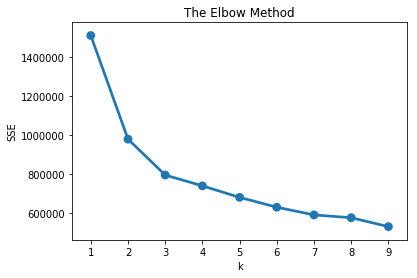

In [33]:
# Definir a quantidade de clusters através do método do cotovelo
import datetime

sse = {}

for k in range(1, 10):
    #print(k)
    #print(datetime.datetime.now())
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_encoded_normalized)
    sse[k] = kmeans.inertia_ 
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [53]:
k=3

kmeans = KMeans(n_clusters=k, random_state=1).fit(data_encoded_normalized)
data_encoded_normalized['CLUSTER'] = kmeans.labels_

#data_encoded_normalized = data_encoded_normalized.reset_index()
data_encoded_normalized_final = data_encoded_normalized

data_encoded_normalized_final = data_encoded_normalized_final.merge(df1[['id','portfolio_1']],on=['id'],how='left',suffixes=('','_1'))
data_encoded_normalized_final.head(3)

data_encoded_normalized_final = data_encoded_normalized_final.merge(df2[['id','portfolio_2']],on=['id'],how='left',suffixes=('_1','_2'))
data_encoded_normalized_final.head(3)

data_encoded_normalized_final = data_encoded_normalized_final.merge(df3[['id','portfolio_3']],on=['id'],how='left',suffixes=('','_3'))
data_encoded_normalized_final.head(3)

,id,qt_filiais,fl_rm,fl_telefone,fl_email,fl_st_especial,idade_empresa_anos,fl_matriz,fl_spa,vl_faturamento_estimado_aux,...,AGROPECUARIA,COMERCIO,CONSTRUÇÃO CIVIL,INDUSTRIA,OUTROS,SERVIÇO,CLUSTER,portfolio_1,portfolio_2,portfolio_3
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,0.0,1.0,1.0,1.0,0.0,0.135704,1.0,0.0,0.000215,...,0.0,0.0,1.0,0.0,0.0,0.0,2,NaN,NaN,NaN
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,0.0,1.0,1.0,1.0,0.0,0.013594,1.0,0.0,0.000014,...,0.0,0.0,0.0,0.0,0.0,1.0,2,NaN,NaN,NaN
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,0.0,1.0,1.0,0.0,0.0,0.066500,1.0,0.0,0.000003,...,0.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN,NaN


In [54]:
data_encoded_normalized_final.groupby(['CLUSTER'])['id'].count()

CLUSTER
0     99704
1    211224
2    151370
Name: id, dtype: int64

In [55]:
data_encoded_normalized_final.groupby(['portfolio_1','CLUSTER'])['id'].count()

portfolio_1  CLUSTER
1.0          0            3
             1          496
             2           56
Name: id, dtype: int64

In [56]:
data_encoded_normalized_final.groupby(['portfolio_2','CLUSTER'])['id'].count()

portfolio_2  CLUSTER
2.0          0          204
             1          107
             2          255
Name: id, dtype: int64

In [57]:
data_encoded_normalized_final.groupby(['portfolio_3','CLUSTER'])['id'].count()

portfolio_3  CLUSTER
3.0          0          147
             2          118
Name: id, dtype: int64

In [60]:
data_encoded_normalized_final[['id','CLUSTER']].to_csv('banco_dados.csv')